## Дипломная работа на тему "Предсказание цен на поддержанные автомобили в США в соответствии с данными сайта craigslist.org"

## 1. Описание

Craigslist.org - одна из крупнейших интернет-площадок электронных объявлений в мире, особенно пользующаяся большой популярностью в США. Подавляющую часть этого сайта занимают объявления о продаже поддержанных автомобилей. 

Представленный [набор данных](https://www.kaggle.com/austinreese/craigslist-carstrucks-data) обновляется каждый месяц и содержит исчерпывающую информацию об автомобилях, которую предоставляет сайт craigslist.org, включая сведения о марке и модели автомобиля, его состоянии, цене продажи, пробеге и т.д. Актуальная версия набора данных представлена от 09.2020

В рамках выполнения дипломной работы необходимо решить задачу регрессии и построить соответствующую модель, предсказывающую цены на поддержанные автомобили. Для проверки качества регрессии использовать метрики RMSE и MAE.

## 2. Data Understanding

### 2.1. Подключение библиотек

In [145]:
# modelling helpers
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# data handling and preparation
import numpy as np
import pandas as pd

# visualization
from jupyterthemes import jtplot
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sns
%matplotlib inline
jtplot.style()

### 2.2. Вспомогательные функции

In [3]:
def print_obj_columns(data):
    obj_cols = list(data.select_dtypes(include=['object']).columns)
    for col in data[obj_cols]:
        print(f'{col}:')
        print(f'Len of unique items list: {len(data[col].unique())}')
        if col == 'description':
            print('Item length is too long to print')
            print('-'*40)
            continue
        if len(data[col].unique()) > 20:
            print(f'{data[col].unique()[:5]}')
        else:
            print(f'{data[col].unique()}')
        print('-'*40)

        
def plot_variable_importance(X, y):
    tree = RandomForestRegressor(random_state = 419)
    tree.fit(X, y)
    plot_model_var_imp(tree, X, y)
    
    
def plot_model_var_imp(model, X, y):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = ['Importance'] , 
        index = X.columns 
    )
    imp = imp.sort_values(['Importance'], ascending=True)
    imp[:10].plot(kind = 'barh')

### 2.3. Загрузка данных

In [4]:
data = pd.read_csv('../data/external/vehicles.csv')
data.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7184791621,https://duluth.craigslist.org/ctd/d/duluth-200...,duluth / superior,https://duluth.craigslist.org,6995,2000.0,gmc,new sierra 1500,excellent,8 cylinders,...,4wd,NaN,NaN,red,https://images.craigslist.org/00n0n_f06ykBMcdh...,2000 *** GMC New Sierra 1500 Ext Cab 157.5 WB...,NaN,mn,46.8433,-92.2550
1,7184773187,https://duluth.craigslist.org/cto/d/saginaw-20...,duluth / superior,https://duluth.craigslist.org,8750,2013.0,hyundai,sonata,excellent,4 cylinders,...,fwd,NaN,NaN,grey,https://images.craigslist.org/00d0d_kgZ6xoeRw2...,For Sale: 2013 Hyundai Sonata GLS - $8750. O...,NaN,mn,46.9074,-92.4638
2,7193375964,https://newhaven.craigslist.org/cto/d/stratfor...,new haven,https://newhaven.craigslist.org,10900,2013.0,toyota,prius,good,4 cylinders,...,fwd,NaN,NaN,blue,https://images.craigslist.org/00d0d_3sHGxPbY2O...,2013 Prius V Model Two. One owner—must sell my...,NaN,ct,41.1770,-73.1336
3,7195108810,https://albuquerque.craigslist.org/cto/d/albuq...,albuquerque,https://albuquerque.craigslist.org,12500,2003.0,mitsubishi,lancer,good,4 cylinders,...,4wd,mid-size,sedan,grey,https://images.craigslist.org/00m0m_4a8Pb6JbMG...,"2003 Mitsubishi Lancer Evolution, silver. Abo...",NaN,nm,35.1868,-106.6650
4,7184712241,https://duluth.craigslist.org/ctd/d/rush-city-...,duluth / superior,https://duluth.craigslist.org,16995,2007.0,gmc,sierra classic 2500hd,good,8 cylinders,...,4wd,full-size,truck,white,https://images.craigslist.org/01414_g093aPtSMW...,"**Bad Credit, No Credit... No Problem!**2007 G...",NaN,mn,45.6836,-92.9648


In [5]:
data.shape

(423857, 25)

**Описание переменных**

Полный список признаков представлен в отчете по дипломной работе.

Целевая переменная:
* цена (в долларах США)

### 2.4. Предварительный анализ

Проведем предварительный анализ данных для идентификации выбросов, пропусков и признаков, которые являются лишними и от которых можно избавиться.

In [6]:
data.describe()

,id,price,year,odometer,county,lat,long
count,4.238570e+05,4.238570e+05,328743.000000,2.705850e+05,0.0,324404.000000,324404.000000
mean,7.190602e+09,5.779437e+04,2009.827358,9.942578e+04,NaN,38.731429,-93.949367
std,5.159269e+06,1.002581e+07,10.135809,1.204833e+05,NaN,5.902977,17.930566
min,7.178302e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-80.386400,-161.394000
25%,7.186688e+09,4.499000e+03,2007.000000,4.432400e+04,NaN,35.054500,-106.678000
50%,7.192068e+09,9.995000e+03,2012.000000,9.174900e+04,NaN,39.366900,-88.009900
75%,7.194909e+09,1.899500e+04,2016.000000,1.372370e+05,NaN,42.517075,-80.832500
max,7.197006e+09,3.808256e+09,2021.000000,1.000000e+07,NaN,80.383400,115.524000


In [7]:
print_obj_columns(data)

url:
Len of unique items list: 423857
['https://duluth.craigslist.org/ctd/d/duluth-2000-gmc-new-sierra-1500-ext-cab/7184791621.html'
 'https://duluth.craigslist.org/cto/d/saginaw-2013-hyundai-sonata-gls/7184773187.html'
 'https://newhaven.craigslist.org/cto/d/stratford-2013-toyota-prius-2-wagon-4d/7193375964.html'
 'https://albuquerque.craigslist.org/cto/d/albuquerque-mitsubishi-lancer-evolution/7195108810.html'
 'https://duluth.craigslist.org/ctd/d/rush-city-2007-gmc-sierra-classic/7184712241.html']
----------------------------------------
region:
Len of unique items list: 404
['duluth / superior' 'new haven' 'albuquerque' 'lubbock'
 'fargo / moorhead']
----------------------------------------
region_url:
Len of unique items list: 413
['https://duluth.craigslist.org' 'https://newhaven.craigslist.org'
 'https://albuquerque.craigslist.org' 'https://lubbock.craigslist.org'
 'https://fargo.craigslist.org']
----------------------------------------
manufacturer:
Len of unique items list: 44

In [8]:
data.isna().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year             95114
manufacturer    110615
model            98473
condition       247138
cylinders       226178
fuel             96643
odometer        153272
title_status     96098
transmission     95792
vin             239437
drive           192738
size            321230
type            182700
paint_color     201654
image_url        94196
description      94203
county          423857
state                0
lat              99453
long             99453
dtype: int64

**Результаты предварительного анализа**

1. Необходимо избавиться от признаков, которые в дальнейшем не повлияют (или влияние будет крайне мало) на конечную стоимость продаваемого автомобиля (идентификаторы, url'ы, VIN-номер, описание, координаты и т.д.).
2. Заменить нулевые показания стоимости и пробега на средние по рынку.
3. Заменить значения года производства на взвешенные.
4. Заменить пропуски на средние или медианные значения (в зависимости от признака).
5. Закодировать категориальные признаки с использованием OneHotEncoding (для возможности построения линейных моделей и получения корректных результатов).
6. Проведение over/undersampling нецелесообразно. У нас имеется достаточная выборка данных для построения модели.


## 3. Подготовка данных и EDA

### 3.1. Подготовка данных

1. Избавимся от лишних признаков

In [198]:
data.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')

In [199]:
drops = ['id', 'url', 'manufacturer', 'cylinders', 'region', 'region_url', 'county', 'lat', 'long', 'state', 'image_url', 'description', 'vin', 'model', 'type', 'paint_color']
reduced = data.drop(columns=drops)
reduced.head()

,price,year,condition,fuel,odometer,title_status,transmission,drive,size
0,6995,2000.0,excellent,gas,167783.0,clean,automatic,4wd,NaN
1,8750,2013.0,excellent,gas,90821.0,clean,automatic,fwd,NaN
2,10900,2013.0,good,hybrid,92800.0,clean,automatic,fwd,NaN
3,12500,2003.0,good,gas,NaN,clean,manual,4wd,mid-size
4,16995,2007.0,good,diesel,254217.0,clean,automatic,4wd,full-size


2. Избавимся от выбросов признака "год производства" и заменим пропуски на взвешенные значения

In [200]:
reduced[reduced['year']==reduced['year'].min()].head()

,price,year,condition,fuel,odometer,title_status,transmission,drive,size
3321,0,1900.0,NaN,gas,NaN,clean,other,NaN,NaN
3349,0,1900.0,NaN,gas,NaN,clean,other,NaN,NaN
54988,0,1900.0,NaN,gas,NaN,clean,other,NaN,NaN
55048,0,1900.0,NaN,gas,NaN,clean,other,NaN,NaN
55350,150,1900.0,NaN,gas,NaN,clean,other,NaN,NaN


Как можно видеть, по автомобилям минимального года производства нет никакой информации, поэтому их можно рассматривать как выбросы. Также нас не будут интересовать модели производства ранее 1960 года (такие экземпляры единичны и не окажут существенного влияния на конечный результат).

In [201]:
reduced.drop(reduced[reduced['year'] < 1960].index, inplace=True)
reduced = reduced[reduced['year'].notna()]
reduced['year'] = reduced['year'] - reduced['year'].min()

3. Избавимся от выбросов значений цены и пробега и ограничим минимальное и максимальное значения; избавимся от отсутствующих значений пробега

In [202]:
reduced.drop(reduced[reduced['price'] > 1000000].index, inplace=True)
reduced.drop(reduced[reduced['price'] < 100].index, inplace=True)

reduced.drop(reduced[reduced['odometer'] > 500000].index, inplace=True)
reduced = reduced[reduced['odometer'].notna()]

4. Заменим пропущенные значения категориальных признаков (на моду или значение 'other')

In [203]:
print_obj_columns(reduced)

condition:
Len of unique items list: 7
['excellent' 'good' 'fair' nan 'like new' 'new' 'salvage']
----------------------------------------
fuel:
Len of unique items list: 6
['gas' 'hybrid' 'diesel' 'electric' 'other' nan]
----------------------------------------
title_status:
Len of unique items list: 7
['clean' 'lien' 'rebuilt' 'salvage' nan 'parts only' 'missing']
----------------------------------------
transmission:
Len of unique items list: 4
['automatic' 'manual' 'other' nan]
----------------------------------------
drive:
Len of unique items list: 4
['4wd' 'fwd' 'rwd' nan]
----------------------------------------
size:
Len of unique items list: 5
[nan 'full-size' 'mid-size' 'compact' 'sub-compact']
----------------------------------------


In [204]:
reduced['condition'].fillna(reduced['condition'].mode()[0], inplace=True)
reduced['fuel'] = reduced['fuel'].fillna('other')
reduced['title_status'].fillna(reduced['title_status'].mode()[0], inplace=True)
reduced['transmission'] = reduced['transmission'].fillna('other')
reduced['drive'].fillna(reduced['drive'].mode()[0], inplace=True)
reduced['size'].fillna(reduced['size'].mode()[0], inplace=True)

In [205]:
reduced.head()

,price,year,condition,fuel,odometer,title_status,transmission,drive,size
0,6995,40.0,excellent,gas,167783.0,clean,automatic,4wd,full-size
1,8750,53.0,excellent,gas,90821.0,clean,automatic,fwd,full-size
2,10900,53.0,good,hybrid,92800.0,clean,automatic,fwd,full-size
4,16995,47.0,good,diesel,254217.0,clean,automatic,4wd,full-size
5,13995,52.0,good,gas,188406.0,clean,automatic,4wd,full-size


### 3.2. EDA

Закодируем категориальные переменные с использованием LabelEncoding для построения корреляционной матрицы и графиков распределений

In [166]:
reduced_copy = reduced.copy()
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = reduced_copy.columns.values.tolist()
for col in features:
    if reduced_copy[col].dtype in numerics: 
        continue
    categorical_columns.append(col)
for col in categorical_columns:
    if col in reduced_copy.columns:
        le = LabelEncoder()
        le.fit(list(reduced_copy[col].astype(str).values))
        reduced_copy[col] = le.transform(list(reduced_copy[col].astype(str).values))

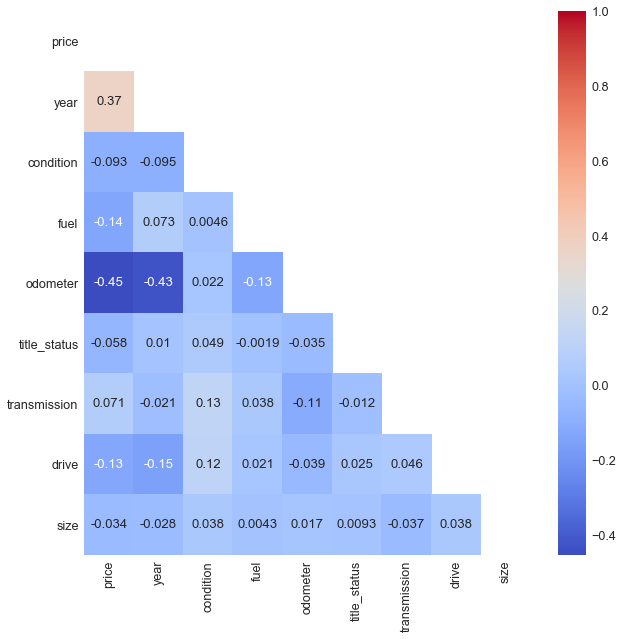

In [167]:
corr = reduced_copy.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(10, 10))
# sns.set(font_scale=1.2)
sns.heatmap(corr, mask=mask, cmap='coolwarm', xticklabels=corr.columns, yticklabels=corr.columns, annot=True, ax=ax)
plt.show()

По корреляционной матрице можем наблюдать, что конечная стоимость автомобиля наиболее зависима от текущего пробега, года производства, типа топлива и типа привода.

In [168]:
reduced_ = reduced.copy()
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = list(reduced_.select_dtypes(include=numerics).columns)
reduced_ = reduced_[num_cols]

Рассмотрим распределение численных переменных. По графикам можем наблюдать, что распределения численных переменных близки к нормальным (с некоторой погрешностью, вызванной оставшимися выбросами и усредненными значениями).

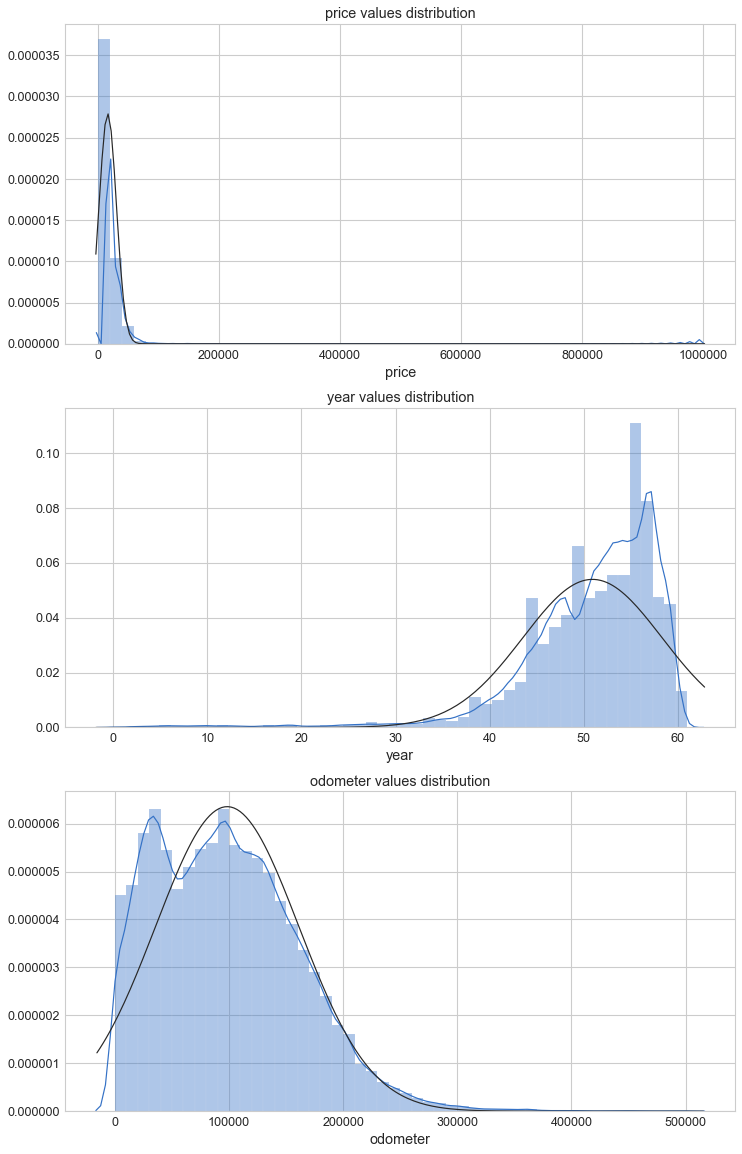

In [185]:
fig = plt.figure(figsize=(12, 20))
for i in range(1, 4):
    ax = plt.subplot(3, 1, i)
    ax.set_title(f'{reduced_.columns[i-1]} values distribution')
    sns_plot = sns.distplot(reduced_[reduced_.columns[i-1]], fit=norm)

Рассмотрим диаграммы размаха некоторых категориальных переменных и их корреляцию с ценой.

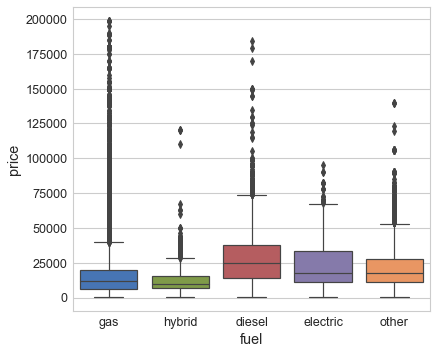

In [186]:
red = reduced[reduced['price'] < 200000]
ax = sns.boxplot(x="fuel", y="price", data=red)

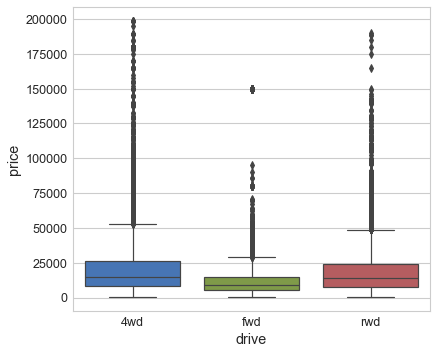

In [187]:
red = reduced[reduced['price'] < 200000]
ax = sns.boxplot(x="drive", y="price", data=red)

По круговой диаграмме категориальных переменных можем наблюдать относительные значения каждого признака и убедиться в том, что, в целом, результаты соответствуют положению дел на автомобильном рынке США.

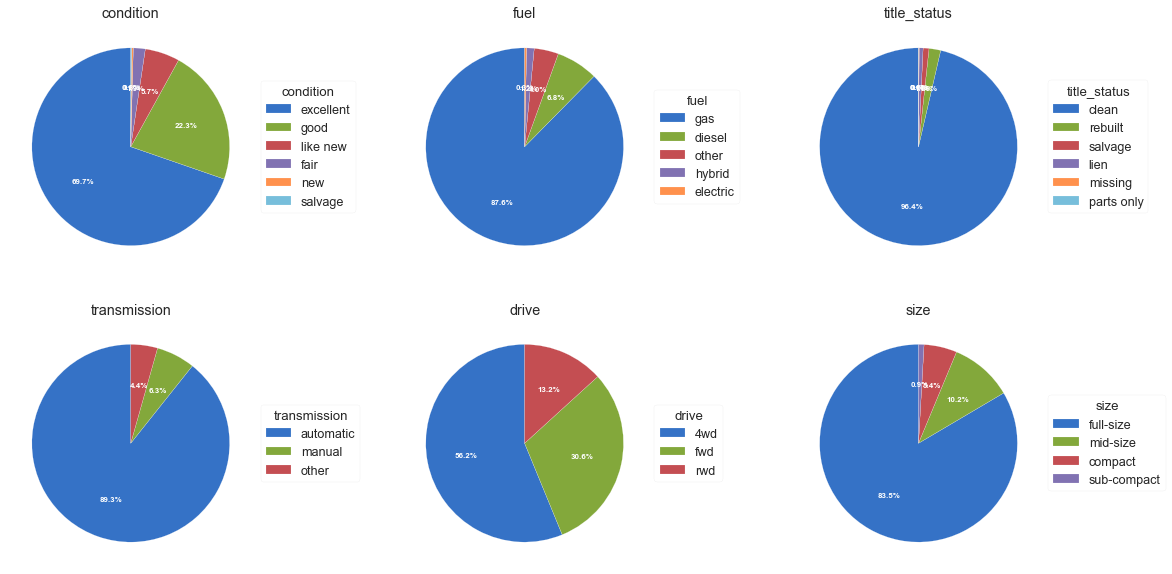

In [188]:
obj_cols = list(reduced.select_dtypes(include=['object']).columns)
plt.figure(figsize=(20, 10))

for i, col in enumerate(reduced[obj_cols]):
    plt.subplot(2, 3, i+1)
    plt.title(col)
    data_ = list(reduced[col].value_counts().to_dict().values())
    labels = reduced[col].value_counts().to_dict().keys()
    patches, texts, autotexts = plt.pie(data_, autopct='%1.1f%%',
                                  textprops=dict(color="w"), startangle=90)

    plt.legend(patches, labels,
          title=col,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
    proptease = fm.FontProperties()
    proptease.set_size('medium')
    plt.setp(autotexts, fontproperties=proptease)
    plt.setp(autotexts, size=8, weight="bold")
    plt.setp(texts, fontproperties=proptease)

### 3.3. Создание датасетов

Закодируем категориальные переменные с использованием One Hot Encoding.

In [206]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = list(reduced.select_dtypes(include=numerics).columns)
obj_cols = list(reduced.select_dtypes(include=['object']).columns)
df = pd.concat([pd.get_dummies(reduced[obj_cols]), reduced[num_cols]], axis=1)

Разделим датасет на обучаемую и тестовую выборки.

In [207]:
X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### 3.3.1. Важность признаков

По графику важности признаков можем наблюдать такие же результаты, которые были получены при построении корреляционной матрицы.

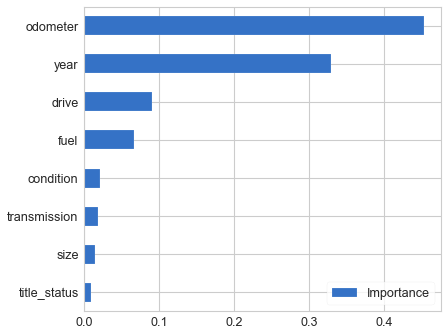

In [208]:
plot_variable_importance(reduced_copy.drop(columns=['price']), reduced_copy['price'])

## 4. Построение модели

**Выбор модели**

Для построения модели и решения задачи регрессии будем использовать линейные модели LinearRegression(...) и ElasticNet(...) и нелинейную модель RandomForestRegressor(...)

In [209]:
model_lr = LinearRegression()
model_en = ElasticNet()
model_rf = RandomForestRegressor(random_state=42)

**Обучение моделей**

In [210]:
%%time
model_lr.fit(X_train, y_train)
model_en.fit(X_train, y_train)
model_rf.fit(X_train, y_train)

Wall time: 2min 24s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

## 5. Оценка модели

Для оценки модели будем использовать метрики RMSE и MAE

In [214]:
y_lr_predict = model_lr.predict(X_test)
y_en_predict = model_en.predict(X_test)
y_rf_predict = model_rf.predict(X_test)

print(f'RMSE evaluation for Linear Regression: {mean_squared_error(y_test, y_lr_predict, squared=False):.4f}')
print(f'RMSE evaluation for Elastic Net: {mean_squared_error(y_test, y_en_predict, squared=False):.4f}')
print(f'RMSE evaluation for Random Forest: {mean_squared_error(y_test, y_rf_predict, squared=False):.4f}')
print()
print(f'MAE evaluation for Linear Regression: {mean_absolute_error(y_test, y_lr_predict):.4f}')
print(f'MAE evaluation for Elastic Net: {mean_absolute_error(y_test, y_en_predict):.4f}')
print(f'MAE evaluation for Random Forest: {mean_absolute_error(y_test, y_rf_predict):.4f}')

RMSE evaluation for Linear Regression: 11107.8228
RMSE evaluation for Elastic Net: 11762.8751
RMSE evaluation for Random Forest: 7907.9832

MAE evaluation for Linear Regression: 6576.0179
MAE evaluation for Elastic Net: 7169.9293
MAE evaluation for Random Forest: 3473.6408


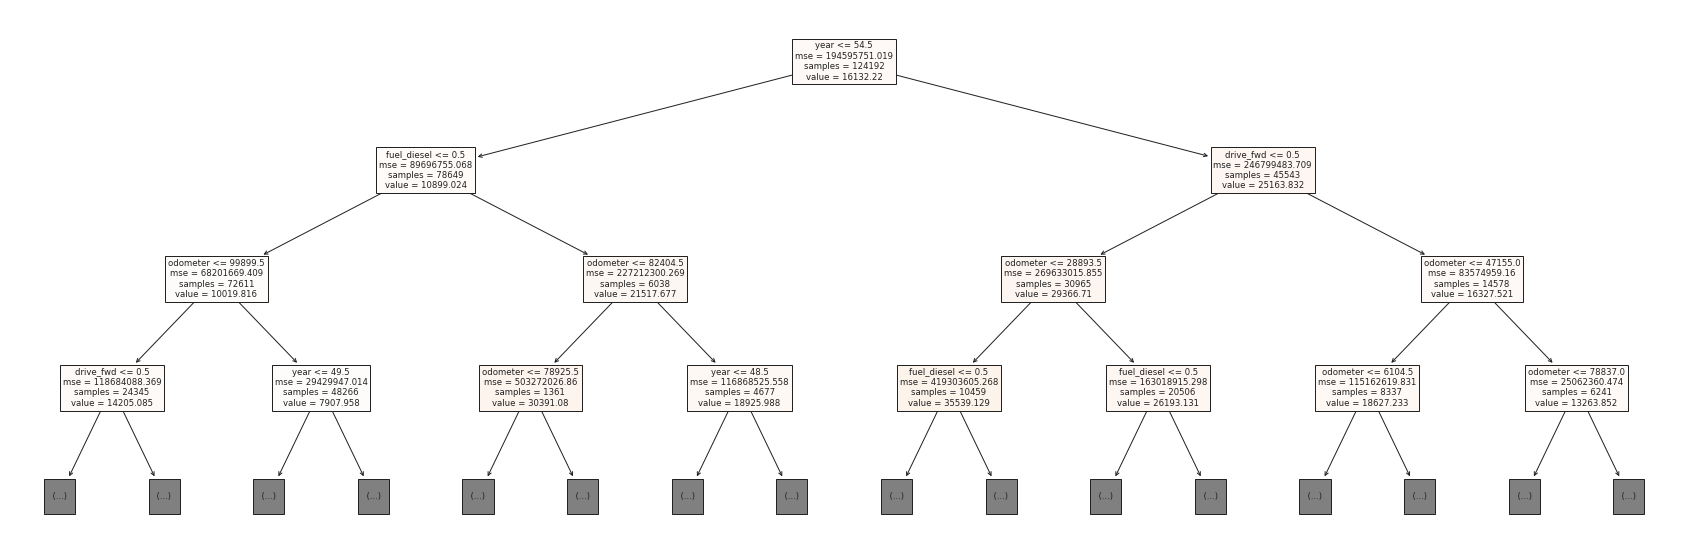

In [244]:
plt.figure(figsize=(30, 10))
with plt.style.context('classic'):
    plot_tree(model_rf.estimators_[0], feature_names=X.columns, max_depth=3, filled=True)
    plt.show()

In [222]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

best = (0, 10000000)
for mi in range(10, 1001):
    lin_model = ElasticNet(max_iter=mi)
    lin_model.fit(X_train, y_train)
    y_predict = lin_model.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_predict, squared=False)
    
    if rmse < best[1]:
        best = (mi, rmse)
    
print(f'\nBest max_iter is {best[0]} with RMSE = {best[1]:.4f}')


Best max_iter is 10 with RMSE = 11664.2937
Wall time: 5min 58s


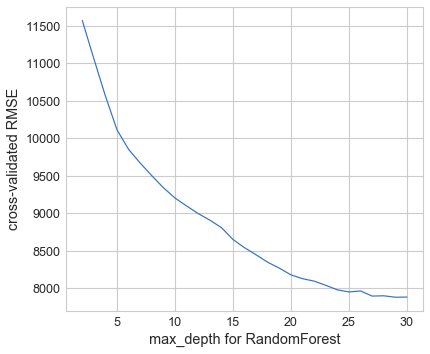

Min depth is 29 for RMSE = 7879.3377
Wall time: 10h 1min 24s


In [223]:
%%time

depth = list(range(2, 31))

param_grid = dict(max_depth=depth)

grid = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=10, scoring='neg_root_mean_squared_error')
grid.fit(X, y)

mean_scores = np.absolute(grid.cv_results_['mean_test_score'])

plt.plot(depth, mean_scores)
plt.xlabel('max_depth for RandomForest')
plt.ylabel('cross-validated RMSE')
plt.show()

best_depth, best_rmse = min(zip(depth, mean_scores), key=lambda x: x[1])
print(f'Min depth is {best_depth} for RMSE = {best_rmse:.4f}')

По графику зависимости значений метрики RMSE от глубины дерева можем наблюдать, что результат обучения модели улучшается при увеличении глубины деревьев.

## 6. Развертывание модели

Сохраним модель в *.csv-файл

In [78]:
pred = pd.DataFrame({'price_pred': y_predict})
df_new = pd.concat([df, pred], axis=1)
df_new.to_csv('../models/used_cars_price_pred.csv')

**Сохранение модели в pickle-файле**

In [79]:
import pickle

with open('../models/used_cars_price_rfr_model.pickle', 'wb') as out_fp:
    pickle.dump(model, out_fp)

## 7. Построение модели с использованием единственного признака

Попробуем построить и оценить модель с использованием единственного признака - пробега (odometer)

In [80]:
X_alt = df['odometer']
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X_alt, y, test_size=0.2)

In [87]:
X_train = np.array(X_train).reshape(-1, 1)
model_ext = RandomForestRegressor(random_state=419)
model_ext.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=419, verbose=0, warm_start=False)

In [248]:
X_test = np.array(X_test).reshape(-1, 1)
y_predict = model_ext.predict(X_test)

print(f'RMSE evaluation: {mean_squared_error(y_test, y_predict, squared=False):.4f}')
print()
print(f'MAE evaluation: {mean_absolute_error(y_test, y_predict):.4f}')

RMSE evaluation: 10530.4146

MAE evaluation: 5761.3969


Полученные результаты для модели, основанной на одном признаке, дают ей право на существование, но для получения более точных результатов необходимо использовать большее количество признаков.